In [29]:
import warnings
warnings.filterwarnings("ignore")
import os

# 移动文件
import shutil

import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('ggplot')

## 先把文件夹里的旧文件删除

In [2]:
# 改变当前路径到
os.chdir(r"/Users/aaronlalala/Downloads")
# 把下载的数据放入指定文件夹

for file in os.listdir():
    if "gzsy" in file:
        print("Locate file")
        shutil.move(file, r"/Users/aaronlalala/Documents/Codes/量化项目/股债利差自动化")
    elif "中国" in file:
        print("Locate China 10-year bond file")
        shutil.move(file, r"/Users/aaronlalala/Documents/Codes/量化项目/股债利差自动化")
    elif "Index" in file:
        print("Locate index file")
        shutil.move(file, r"/Users/aaronlalala/Documents/Codes/量化项目/股债利差自动化")


os.chdir(r"/Users/aaronlalala/Documents/Codes/量化项目/股债利差自动化")

for file in os.listdir():
    if "fullA" in file:
        print("Remove old data")
        os.remove(file)
    elif "hs300" in file:
        print("Remove old hs300")
        os.remove(file)
    elif "zz500" in file:
        print("Remove old zz500")
    elif "bond" in file:
        print("Remove old bond")
        os.remove(file)


for file in os.listdir():
    if "000985" in file:
        print("Rename file")
        os.rename(file, "fullA.xls")
    elif "国债" in file:
        print("Rename bond file")
        os.rename(file, "bond.csv")
    elif "000300" in file:
        print("Rename 沪深300")
        os.rename(file, "hs300.xls")
    elif "000905" in file:
        print("Rename 中证500")
        os.rename(file, "zz500.xls")

Locate index file
Locate index file
Locate China 10-year bond file
Locate index file
Remove old zz500
Remove old bond
Remove old hs300
Remove old data
Rename 沪深300
Rename file
Rename bond file
Rename 中证500


# Function Definition

In [3]:
# 这个rolling_pct是每个历史的数据，在历史的7年窗口上进行一个比较，所有的数据都是站在当时的区间观测得到。
# 该方法已经用抽测过了，是正确的没有错误，可以放心使用。
pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]

In [4]:
# Rolling Window计算百分位
# 要求 1. 已经计算出股债收益率比; 2. 日期为datetime格式 3. 包含"收盘价"为列名
def rolling_window(data, freshDate):
    fresh_data = data[data['日期'] > freshDate]
    fresh_data["PercRank"] = data['股债收益率比'].rank(pct=True)
    fresh_data["rolling_pct"] = data["股债收益率比"].rolling(window=7*250).apply(pctrank)[(fresh_data.iloc[[1]].index[0]-1):]
    return fresh_data.loc[:, ['日期', "收盘价", "rolling_pct", "股债收益率比"]]

In [5]:
# 画图函数
def priceSpreadPlot(data, name):
    # 百分位
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(30, 8))
    ax1.plot(data["日期"], data["rolling_pct"])
    ax1.axhline(y=data['rolling_pct'].iloc[-1], color='k', linestyle='-.')
    ax1.xaxis.set_major_locator(mdates.YearLocator())


    ax1Twin=ax1.twinx()
    ax1Twin.plot(data['日期'], data['收盘价'], color = "blue")
    ax1Twin.get_xaxis().set_visible(False)
    
    # 实际走势
    ax2.plot(data["日期"], data['股债收益率比'])
    ax2.xaxis.set_major_locator(mdates.YearLocator())
    ax2.axhline(y=data['股债收益率比'].iloc[-1], color='k', linestyle='-.')

    plt.xticks(rotation=45)


    plt.title(str(datetime.datetime.today()))
    plt.savefig(name + ".png")

In [6]:
# 如果已经进入买入区间了，那就在近半年的数据上进行更精细化的操作
def recentHalfYear(data):
    fig, ax = plt.subplots(figsize=(10, 5))
    last_days = data.iloc[-120:]
    last_days['日期'] = last_days['日期'].astype(str)
    display(last_days.iloc[-5:])


    
    ax.plot(last_days.loc[:, '日期'], last_days.loc[:, 'rolling_pct'])
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.show()

# Compute Rolling Window Percentage Rank

# 细分3只指数

In [7]:
hs = pd.read_excel("hs300.xls")
zz = pd.read_excel("zz500.xls")
fullA  = pd.read_excel("fullA.xls", sheet_name = "中证全A的估值历史数据")
# bond的数据日期和指数数据日期有点对不齐，2008年之后的数据基本大差不差，只差了个位数的日期，完全可以拿来用。虽然bond的数据更新会慢，但是其他地方数据确实太难找了。
bond = pd.read_csv("bond.csv")

In [8]:
# 计算盈利收益率
def extract_features(data):
    result = data.loc[:, ['日期', "收盘价", "PE_TTM_加权"]]
    result['盈利收益率'] = 1 / result['PE_TTM_加权']
    result['日期'] = result['日期'].astype(str)
    return result

hs = extract_features(hs)
zz = extract_features(zz)
fullA = extract_features(fullA)

In [9]:
# bond的日期格式调整， 比如2021年1月5日 -> 2021-1-5 -> 2021-01-05
bond['日期'] = bond['日期'].str.replace('年', "-")
bond['日期'] = bond['日期'].str.replace('月', "-")
bond['日期'] = bond['日期'].str.replace('日', "")
bond['日期'] = pd.to_datetime(bond['日期'], infer_datetime_format=True).astype(str)

# 只要收盘价格
bond = bond.loc[:, ['日期', "收盘"]]
bond['收盘'] *= 0.01

In [10]:
# 所有数据共有的日期
dates = pd.merge(hs, bond, on = ['日期'], how = "inner").loc[:, '日期']
dates = pd.merge(dates, zz, on = '日期', how = 'inner').loc[:, '日期']
dates = pd.merge(dates, fullA, on = '日期', how = 'inner').loc[:, '日期']
# 筛选这些日期的数据
hs = hs.loc[hs['日期'].isin(dates)].sort_values(by=['日期']).reset_index().drop(columns=['index'])
zz = zz.loc[zz['日期'].isin(dates)].sort_values(by=['日期']).reset_index().drop(columns=['index'])
fullA = fullA.loc[fullA['日期'].isin(dates)].sort_values(by=['日期']).reset_index().drop(columns=['index'])
bond = bond.loc[bond['日期'].isin(dates)].sort_values(by=['日期']).reset_index().drop(columns=['index'])

In [11]:
hs.columns = ['日期', '收盘价', "加权PE", "加权盈利收益率"]
zz.columns = ['日期', '收盘价', "加权PE", "加权盈利收益率"]
fullA.columns = ['日期', '收盘价', "加权PE", "加权盈利收益率"]

hs["股债收益率比"] = hs['加权盈利收益率'].values / bond['收盘'].values
zz["股债收益率比"] = zz['加权盈利收益率'].values / bond['收盘'].values
fullA["股债收益率比"] = fullA['加权盈利收益率'].values / bond['收盘'].values

In [12]:
# 提取最近7年的数据
hs['日期'] = pd.to_datetime(hs['日期'], infer_datetime_format=True)
zz['日期'] = pd.to_datetime(zz['日期'], infer_datetime_format=True)
fullA['日期'] = pd.to_datetime(fullA['日期'], infer_datetime_format=True)

fresh_date = datetime.datetime.now() - datetime.timedelta(days=7*365)

In [13]:
hsSpreadPctRank = rolling_window(hs, fresh_date)
zzSpreadPctRank = rolling_window(zz, fresh_date)
fullASpreadPctRank = rolling_window(fullA, fresh_date)

In [14]:
# hsSpreadPctRank.to_csv("hs_rank.csv")

# 得出结论

## 10年期国债收益率

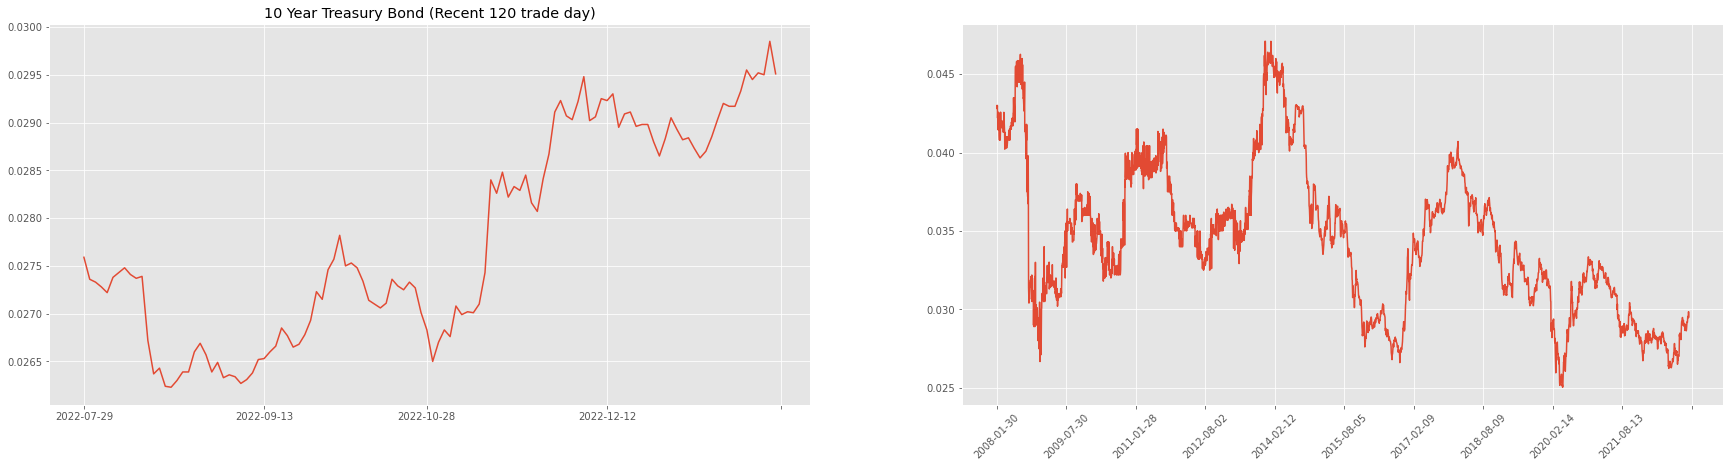

In [15]:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(30, 7))
ax1.plot(bond.iloc[-120:].loc[:, '日期'], bond.iloc[-120:].loc[:, '收盘'])
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_title("10 Year Treasury Bond (Recent 120 trade day)")

ax2.plot(bond.loc[:, '日期'], bond.loc[:, '收盘'])
ax2.xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45)
plt.show()


## 中证全A

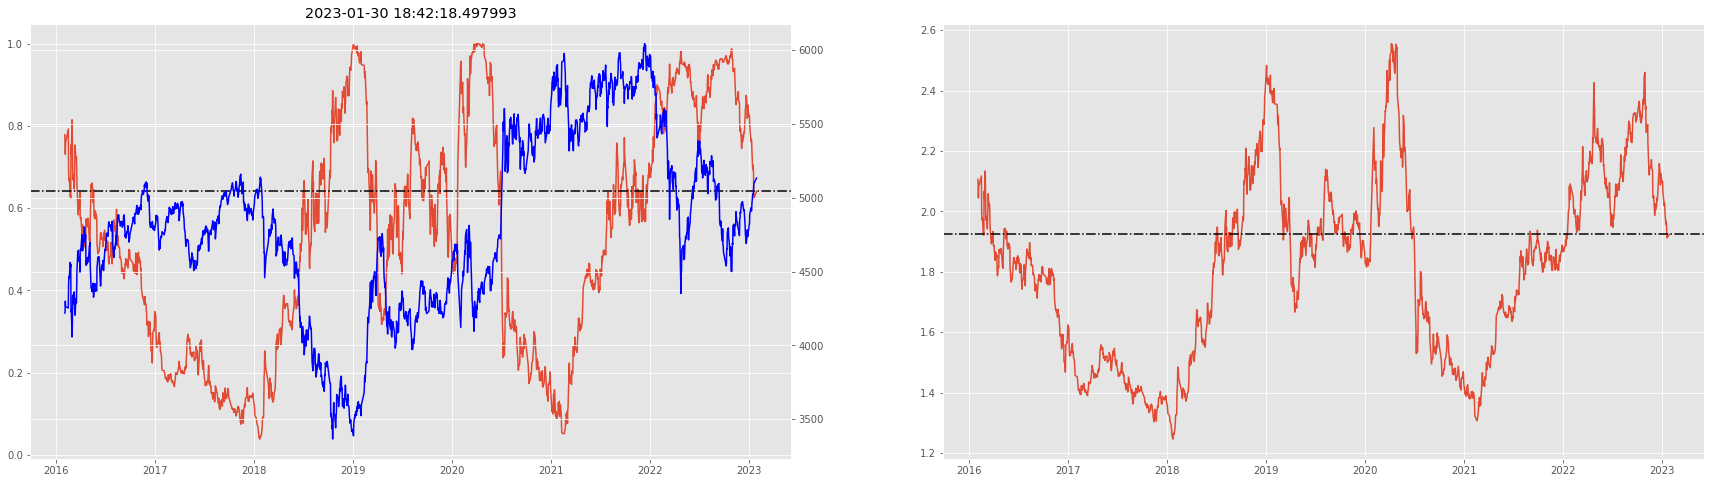

In [16]:
priceSpreadPlot(fullASpreadPctRank, "中证全A")

,日期,收盘价,rolling_pct,股债收益率比
3633,2023-01-17,5022.0493,0.704571,1.967315
3634,2023-01-18,5025.9450,0.695429,1.960378
3635,2023-01-19,5059.3440,0.685143,1.950420
3636,2023-01-20,5096.7804,0.623429,1.912148
3637,2023-01-30,5132.8287,0.640571,1.924294


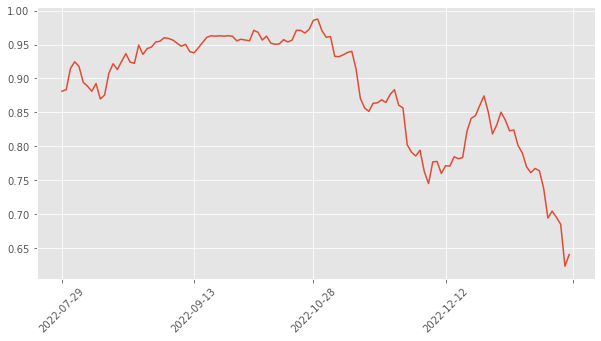

In [17]:
recentHalfYear(fullASpreadPctRank)

## 沪深300 

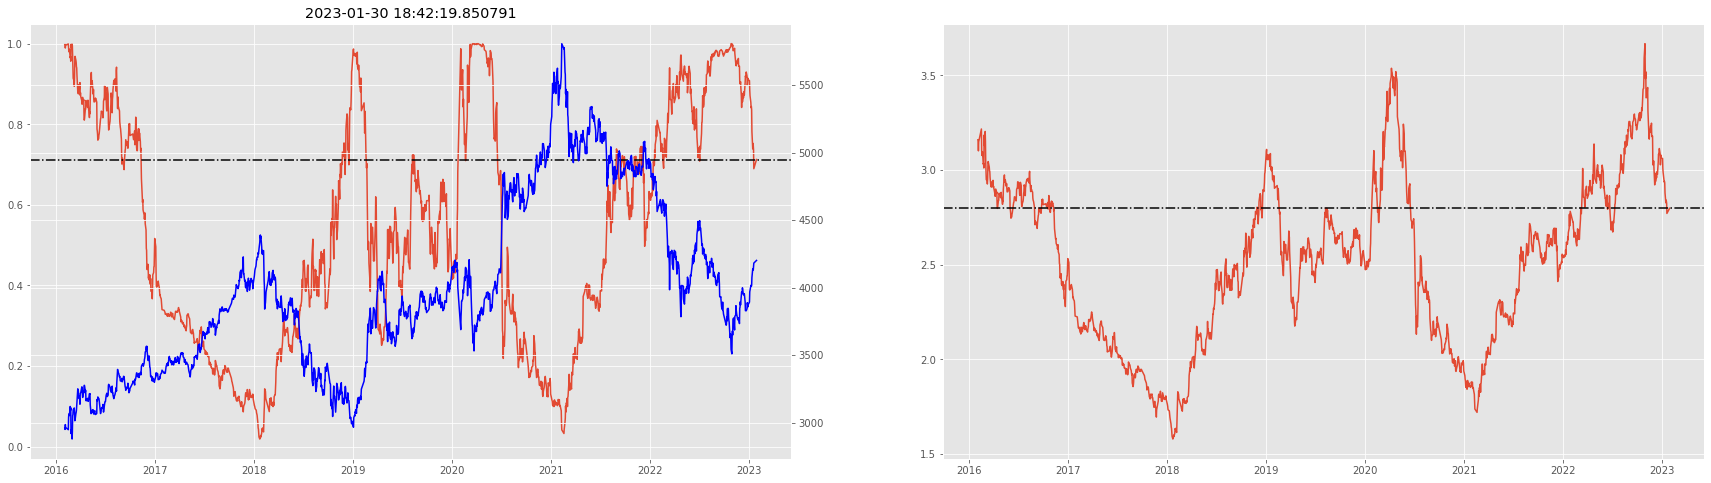

In [18]:
priceSpreadPlot(hsSpreadPctRank, "沪深300")

,日期,收盘价,rolling_pct,股债收益率比
3633,2023-01-17,4137.24,0.752571,2.841494
3634,2023-01-18,4130.31,0.746857,2.834756
3635,2023-01-19,4156.01,0.736571,2.824859
3636,2023-01-20,4181.53,0.689714,2.770954
3637,2023-01-30,4201.35,0.712571,2.798251


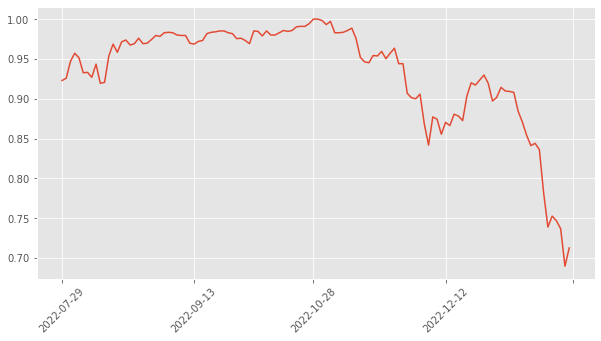

In [19]:
recentHalfYear(hsSpreadPctRank)

## 中证500

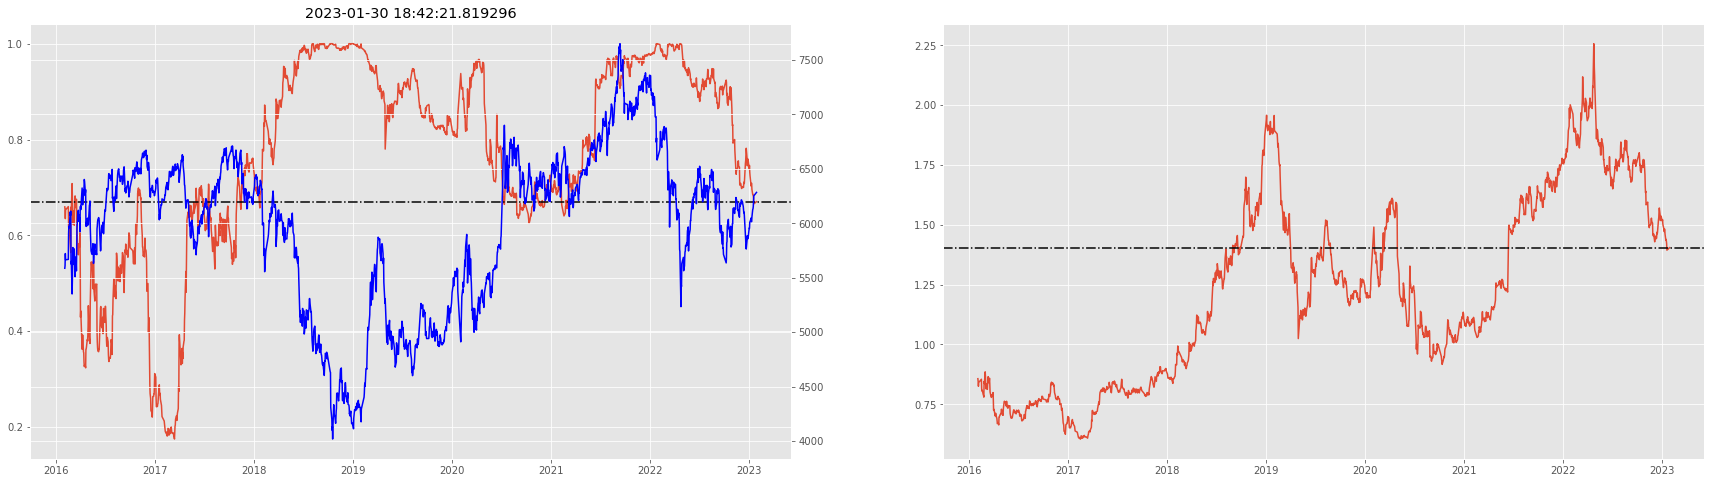

In [20]:
priceSpreadPlot(zzSpreadPctRank, "中证500")

,日期,收盘价,rolling_pct,股债收益率比
3633,2023-01-17,6132.64,0.685143,1.438808
3634,2023-01-18,6151.46,0.682857,1.431756
3635,2023-01-19,6204.33,0.677714,1.420717
3636,2023-01-20,6251.43,0.665714,1.394126
3637,2023-01-30,6283.33,0.670286,1.404344


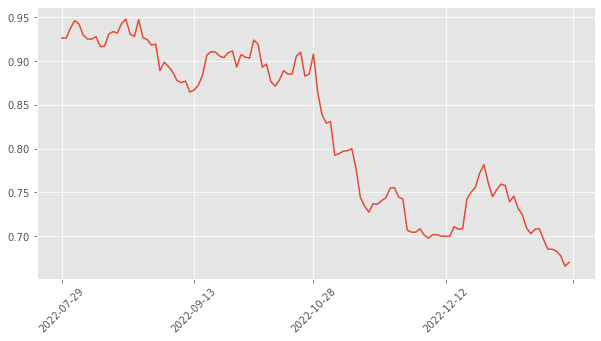

In [21]:
recentHalfYear(zzSpreadPctRank)

# Today's Approximation

In [21]:
# def compute_today(lastday_ratio, priceIncrease, interestIncrease, freshData):
#     today_ratio_approx = lastday_ratio / (priceIncrease + 1) / (1 + interestIncrease)
#     # today_ratio_approx = 3.044148
#     print("Today's ratio is", today_ratio_approx)

#     # Today's ratio's percent rank in recent 7 years.
#     freshData = freshData.iloc[-250*7:].loc[:, "股债收益率比"].append(pd.Series(today_ratio_approx))
#     freshData = freshData.iloc[1:]
#     today_pct_aprox = round(freshData.rank(pct = True).iloc[-1], 6)

#     diff = (today_pct_aprox - hsSpreadPctRank.iloc[-1].loc["rolling_pct"])
#     print("Today's approximated rolling pct is", today_pct_aprox)
#     print("The difference of today and yesterday is", diff)

In [22]:
# last_hs_ratio = 3.063566
# priceIncrease = 0.57 * 0.01
# interestIncrase = 0.31 * 0.01
# compute_today(last_hs_ratio, priceIncrease, interestIncrase, hs)

In [23]:
def price_rolling_window(data, freshDate):
    fresh_data = data[data['日期'] > freshDate]
    fresh_data["PercRank"] = data['收盘价'].rank(pct=True)
    fresh_data["price_rolling_pct"] = data["收盘价"].rolling(window=7*250).apply(pctrank)[(fresh_data.iloc[[1]].index[0]-1):]
    return fresh_data.loc[:, ['日期', "price_rolling_pct", "股债收益率比"]]

hsSpreadPctRank['price_rolling_pct'] = price_rolling_window(hs, fresh_date).loc[:, "price_rolling_pct"]

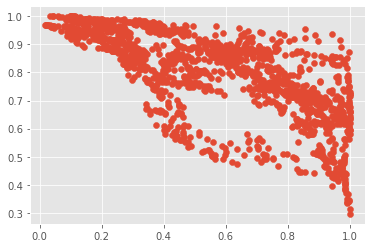

In [24]:
import seaborn as sns
plt.scatter(hsSpreadPctRank["rolling_pct"], hsSpreadPctRank['price_rolling_pct'])

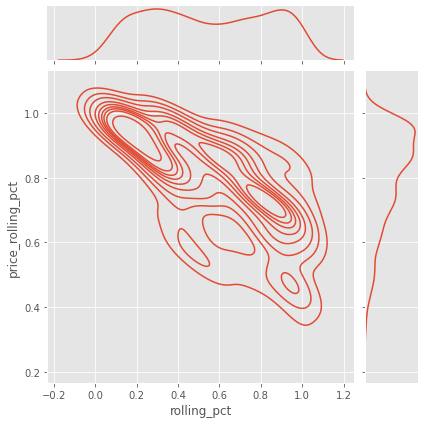

In [25]:
sns.jointplot(
    data=hsSpreadPctRank,
    x="rolling_pct",
    y="price_rolling_pct",
    kind="kde"
)
plt.show()

In [26]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(hsSpreadPctRank["rolling_pct"].values.reshape(-1, 1), hsSpreadPctRank['price_rolling_pct'].values.reshape(-1, 1))
np.corrcoef(hsSpreadPctRank["rolling_pct"].values, hsSpreadPctRank["price_rolling_pct"].values)

array([[ 1.        , -0.72762536],
       [-0.72762536,  1.        ]])

In [29]:
residuals = hsSpreadPctRank["price_rolling_pct"].tail(125).values - reg.predict(hsSpreadPctRank["rolling_pct"].tail(125).values.reshape(-1, 1)).flatten()

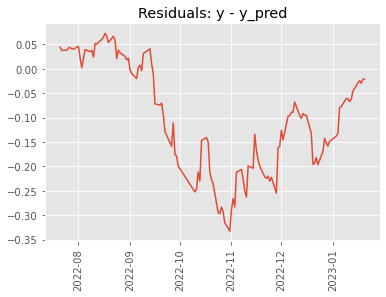

In [31]:
plt.plot(hsSpreadPctRank['日期'].tail(125).values, residuals)
plt.xticks(rotation=90)
plt.title("Residuals: y - y_pred")
plt.show()